In [1]:
# Import all required packages
%matplotlib notebook
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.optimize 
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.models import load_model
from keras.optimizers import Adam

/home/arjun/anaconda3/envs/js-env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
l1 = 10.0
l2 = 8.0
l3 = 6.0
l4 = 4.0

In [3]:
'''
4DOF planar Arm forward Kinematics
Function takes as input the state vector 'q' and returns the joint co-ordinates
Note: Angles must be in radians
'''
def forward_kinematics(q):
    #print('q:' , q)
    t1 = float(q[0])
    t2 = float(q[1])
    t3 = float(q[2])
    t4 = float(q[3])
    
    x1 = l1*math.cos(t1)
    y1 = l1*math.sin(t1)
    
    x2 = x1 + l2*math.cos(t1+t2)
    y2 = y1 + l2*math.sin(t1+t2)
    
    x3 = x2 + l3*math.cos(t1+t2+t3)
    y3 = y2 + l3*math.sin(t1+t2+t3)

    xEE = x3 + l4*math.cos(t1+t2+t3+t4)
    yEE = y3 + l4*math.sin(t1+t2+t3+t4)
    return x1, y1, x2, y2, x3, y3, xEE, yEE

def get_EE_position(q):
    x1, y1, x2, y2, x3, y3, xEE, yEE = forward_kinematics(q)
    return xEE,yEE

In [4]:
def get_jacobian_matrix(q):
    x1, y1, x2, y2, x3, y3, xEE, yEE = forward_kinematics(q)
    J = np.matrix([[-yEE , y1-yEE, y2-yEE, y3-yEE],
                   [xEE, xEE-x1, xEE-x2, xEE-x3]])
    return J

In [5]:
def get_pseudo_inverse(J):
    U, S ,V_T = np.linalg.svd(J, full_matrices=False)
    V = np.transpose(V_T)
    S_inv = np.linalg.inv(np.diag(S))
    return V * S_inv * np.transpose(U)

In [7]:
def get_w1_manipulability(q):
    J = get_jacobian_matrix(q)
    return np.sqrt(np.linalg.det(J*np.transpose(J)))

def objectiveFunction(x):
    return -get_w1_manipulability(x) #+ 100*np.linalg.norm(x)**2

def constraint1(x):
    global xi
    x1, y1, x2, y2, x3, y3, xEE, yEE = forward_kinematics(x)
    _xi = np.array([xEE,yEE])
    return xi - _xi

def constraint2(x):
    global xi
    x1, y1, x2, y2, x3, y3, xEE, yEE = forward_kinematics(x)
    _xi = np.array([xEE,yEE])
    return _xi - xi

In [8]:
q = np.array([10, 20, 30, 40])* math.pi/180.
xi = 0 
xi_data =[]
q_star_data = []

delta = 5
for a1 in range(5,50, delta):
    for a2 in range(5,50, delta):
        for a3 in range(5,50, delta):
            for a4 in range(5,50, delta):
                q[0] = a1 * np.pi/180.
                q[1] = a2 * np.pi/180.
                q[2] = a3 * np.pi/180.
                q[3] = a4 * np.pi/180.

                x1, y1, x2, y2, x3, y3, xEE, yEE = forward_kinematics(q)
                xi = np.array([xEE, yEE])
                xi_data.append(xi)

                #print (xi)
                xopt = scipy.optimize.fmin_cobyla(objectiveFunction, q, [constraint1, constraint2] , rhoend = 1e-8)
                q_star_data.append(xopt* 180./np.pi)
                
                #x1, y1, x2, y2, x3, y3, xEE, yEE = forward_kinematics(xopt)
                #print('in deg: ', xopt*180/math.pi)
                #print(np.linalg.norm(q) , ":", np.linalg.norm(xopt))
                #print(xEE, yEE)

In [9]:
print(len(xi_data))

6561


<IPython.core.display.Javascript object>


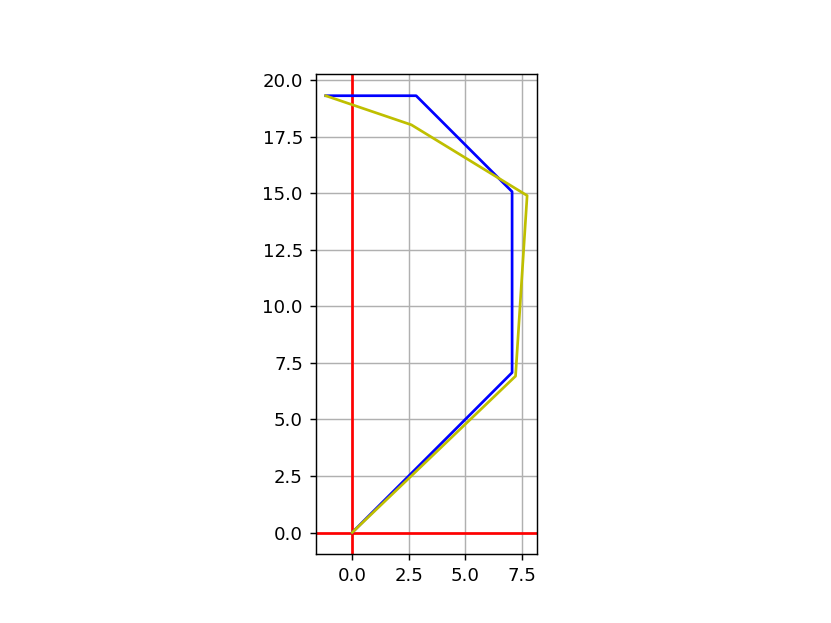

In [10]:
x1, y1, x2, y2, x3, y3, xEE, yEE = forward_kinematics(q)

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.grid(True, which='both')
ax.axhline(y=0, color='r')
ax.axvline(x=0, color='r')

ax.plot([0, x1, x2, x3, xEE] , [0, y1, y2, y3, yEE], 'b')
x1, y1, x2, y2, x3, y3, xEE, yEE = forward_kinematics(xopt)
ax.plot([0, x1, x2, x3, xEE] , [0, y1, y2, y3, yEE], 'y')


plt.show()

In [24]:
NUM_EPOCHS = 300
BATCH_SIZE = 128

X_train = np.array(xi_data)
minval = np.min(X_train)
maxval = np.max(X_train)

def normalize_data(x):
    a = -1.0
    b = 1.0
    data_min = minval
    data_max = maxval
    return a + ((x - data_min)*(b-a))/ (data_max - data_min)

X_train = normalize_data(xi_data)
y_train = np.array(q_star_data) 

model = Sequential()
#filename = "model.h5"

print ("Creating new model")
model.add( Dense( 10, activation = 'relu' , input_shape=[2]) )
model.add( Dense( 10, activation = 'relu') )
model.add( Dense( 10, activation = 'relu' ) )
model.add( Dense( 4 ) )

# Compile Model
model.compile(optimizer=Adam(lr=1e-2), loss="mse")
model.fit(X_train, y_train, shuffle=True, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.1)


Creating new model
Train on 5904 samples, validate on 657 samples
Epoch 1/300
5904/5904 [==============================] - 0s 57us/step - loss: 492.9818 - val_loss: 270.6507
Epoch 2/300
5904/5904 [==============================] - 0s 10us/step - loss: 84.4083 - val_loss: 144.0371
Epoch 3/300
5904/5904 [==============================] - 0s 9us/step - loss: 62.0725 - val_loss: 136.7981
Epoch 4/300
5904/5904 [==============================] - 0s 11us/step - loss: 57.9979 - val_loss: 135.2246
Epoch 5/300
5904/5904 [==============================] - 0s 10us/step - loss: 54.3261 - val_loss: 128.7443
Epoch 6/300
5904/5904 [==============================] - 0s 12us/step - loss: 50.6260 - val_loss: 128.0689
Epoch 7/300
5904/5904 [==============================] - 0s 11us/step - loss: 42.2222 - val_loss: 85.1783
Epoch 8/300
5904/5904 [==============================] - 0s 11us/step - loss: 23.7647 - val_loss: 65.1219
Epoch 9/300
5904/5904 [==============================] - 0s 10us/step - loss: 7.

5904/5904 [==============================] - 0s 13us/step - loss: 1.4710 - val_loss: 16.5017
Epoch 78/300
5904/5904 [==============================] - 0s 15us/step - loss: 1.4626 - val_loss: 15.6239
Epoch 79/300
5904/5904 [==============================] - 0s 14us/step - loss: 1.4241 - val_loss: 16.7585
Epoch 80/300
5904/5904 [==============================] - 0s 13us/step - loss: 1.5567 - val_loss: 16.7847
Epoch 81/300
5904/5904 [==============================] - 0s 15us/step - loss: 1.3844 - val_loss: 15.9760
Epoch 82/300
5904/5904 [==============================] - 0s 15us/step - loss: 1.4445 - val_loss: 15.9257
Epoch 83/300
5904/5904 [==============================] - 0s 13us/step - loss: 1.4058 - val_loss: 16.4187
Epoch 84/300
5904/5904 [==============================] - 0s 12us/step - loss: 1.4333 - val_loss: 17.1250
Epoch 85/300
5904/5904 [==============================] - 0s 15us/step - loss: 1.5899 - val_loss: 16.5205
Epoch 86/300
5904/5904 [==============================] - 0

Epoch 154/300
5904/5904 [==============================] - 0s 9us/step - loss: 1.3334 - val_loss: 14.5197
Epoch 155/300
5904/5904 [==============================] - 0s 10us/step - loss: 1.9557 - val_loss: 16.7412
Epoch 156/300
5904/5904 [==============================] - 0s 10us/step - loss: 1.4383 - val_loss: 16.4011
Epoch 157/300
5904/5904 [==============================] - 0s 9us/step - loss: 1.3768 - val_loss: 16.7249
Epoch 158/300
5904/5904 [==============================] - 0s 9us/step - loss: 1.3773 - val_loss: 16.1662
Epoch 159/300
5904/5904 [==============================] - 0s 10us/step - loss: 1.3706 - val_loss: 14.4476
Epoch 160/300
5904/5904 [==============================] - 0s 9us/step - loss: 1.9853 - val_loss: 15.7196
Epoch 161/300
5904/5904 [==============================] - 0s 8us/step - loss: 1.3776 - val_loss: 15.7295
Epoch 162/300
5904/5904 [==============================] - 0s 9us/step - loss: 1.3388 - val_loss: 16.0163
Epoch 163/300
5904/5904 [==================

Epoch 231/300
5904/5904 [==============================] - 0s 10us/step - loss: 1.3425 - val_loss: 15.1351
Epoch 232/300
5904/5904 [==============================] - 0s 10us/step - loss: 1.2472 - val_loss: 16.2286
Epoch 233/300
5904/5904 [==============================] - 0s 10us/step - loss: 1.3145 - val_loss: 16.0641
Epoch 234/300
5904/5904 [==============================] - 0s 9us/step - loss: 1.3548 - val_loss: 14.9472
Epoch 235/300
5904/5904 [==============================] - 0s 9us/step - loss: 1.2685 - val_loss: 14.8860
Epoch 236/300
5904/5904 [==============================] - 0s 9us/step - loss: 1.1843 - val_loss: 15.6298
Epoch 237/300
5904/5904 [==============================] - 0s 9us/step - loss: 1.2635 - val_loss: 14.9361
Epoch 238/300
5904/5904 [==============================] - 0s 8us/step - loss: 1.2597 - val_loss: 15.7453
Epoch 239/300
5904/5904 [==============================] - 0s 8us/step - loss: 1.1916 - val_loss: 14.1578
Epoch 240/300
5904/5904 [==================

In [19]:
def predict_q(xi):
    a1 = model.predict(xi)[0][0] 
    a2 = model.predict(xi)[0][1] 
    a3 = model.predict(xi)[0][2]
    a4 = model.predict(xi)[0][3] 
    return np.array([a1, a2, a3, a4])

In [21]:
#q = np.array([10, 20, 30, 40])* math.pi/180
x1, y1, x2, y2, x3, y3, xEE, yEE = forward_kinematics(q)

# xi = np.array([[xEE, yEE]])
# print(xi)
# xi = normalize_data(xi)
# print(predict_q(xi))

xi = np.array([[15.,15.5]])
xi = normalize_data(xi)
q = predict_q(xi) * np.pi/180.
print(get_EE_position(q))


(14.222495911643758, 15.5442354314712)


$$\dot{q} = J^+ \dot{\xi} + (I - J^+ J)r$$
$$r^*$$

In [ ]:
def null_space_projector(q):
    J = get_jacobian_matrix(q)
    Jplus = get_pseudo_inverse(J)
    return  (I - JPlus * J)


qDot = null_space_projector(q)*r